In [34]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import re
import imp
import ast
import matplotlib
import funcs
imp.reload(funcs)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

In [35]:
load_path = os.path.join('..', '..', '..', 'data', 'subjects_behavior_alpha_600.pkl')
alpha_table = pd.read_pickle(load_path)

exp_info = funcs.load_info()
rpm_answers = funcs.load_rpm_answers()
subjects_behavior = funcs.load_subjects_behavior()

rpm_difficulty = pd.DataFrame(columns=['question', 'average time', 'difficulty'])
rpm_difficulty['question'] = rpm_answers['question'][0:82]
df = subjects_behavior[(subjects_behavior['reaction time'] != 0) & (subjects_behavior['task time'] == 'pre')]
for i in range(82):
    question_index = rpm_difficulty['question'][i]
    rts = df[df['question'] == question_index]['reaction time']
    rpm_difficulty['average time'][i] = rts.mean()
    
conditions = [
    (rpm_difficulty['average time'] < 10),
    (rpm_difficulty['average time'] >= 10) & (rpm_difficulty['average time'] <= 20),
    (rpm_difficulty['average time'] > 20)
]
choices = [1, 2, 3]
rpm_difficulty['difficulty'] = np.select(conditions, choices)
# rpm_difficulty

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  subjects_behavior = pd.concat([subjects_behavior, one_behavior], ignore_index=True)


### Adjacency

Opening raw data file ..\..\..\data\26\raw_26_1.fif...
    Read a total of 1 projection items:
        EOG-eeg--0.200-0.200-PCA-01 (1 x 31) active
    Range : 0 ... 5567282 =      0.000 ...  1159.850 secs
Ready.
Reading 0 ... 5567282  =      0.000 ...  1159.850 secs...


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_30976\233147612.py:49: RuntimeWarning: This filename (..\..\..\data\26\raw_26_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_path, preload=True)


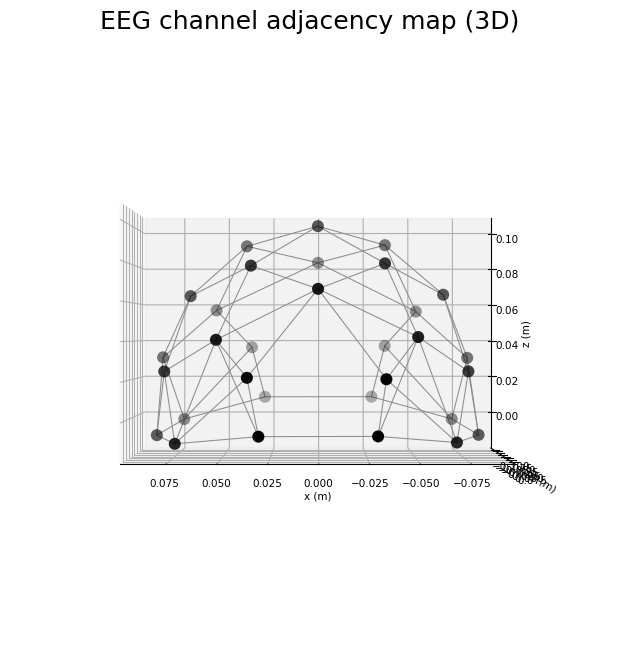

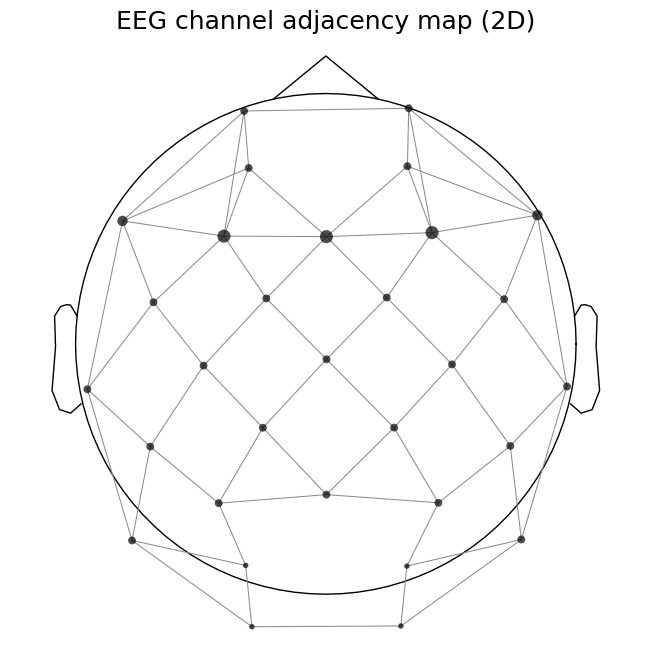

In [103]:
from scipy.sparse import csr_matrix
from scipy.spatial import distance_matrix

def compute_adjacency():
    eeg_data = np.zeros((31, 2))
    # get placement data of standard 10-20 system
    montage_1020 = mne.channels.make_standard_montage('standard_1020')
    positions_1020 = montage_1020._get_ch_pos()
    ch_names = ['Fp1', 'Fp2', 
                'AF3', 'AF4', 
                'F7', 'F3', 'Fz', 'F4', 'F8',
                'FC5', 'FC1', 'FC2', 'FC6',
                'T7', 'C3', 'Cz', 'C4', 'T8',
                'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8',
                'PO3', 'PO4',
                'O1', 'O2']
    ch_types = ['eeg'] * 31
    info = mne.create_info(ch_names, sfreq=4800, ch_types=ch_types, verbose=False)
    raw = mne.io.RawArray(eeg_data, info, verbose=False)

    elec_coords = {ch: positions_1020[ch] for ch in ch_names}
    montage = mne.channels.make_dig_montage(elec_coords, coord_frame='head')
    raw.set_montage(montage)
    
    # Extract the 3D coordinates
    pos = np.stack([raw.info['dig'][i]['r'] for i in range(len(raw.info['dig'])) if raw.info['dig'][i]['kind'] == mne.io.constants.FIFF.FIFFV_POINT_EEG])
    
    # Calculate the distance matrix
    dist_matrix = distance_matrix(pos, pos)
    
    # Define adjacency based on distance threshold
    threshold = np.percentile(dist_matrix, 16.5)  # !!!!! 17.5th percentile of distances as threshold
    adjacency_matrix = dist_matrix < threshold
    
    return adjacency_matrix


ch_names = ['Fp1', 'Fp2', 
            'AF3', 'AF4', 
            'F7', 'F3', 'Fz', 'F4', 'F8',
            'FC5', 'FC1', 'FC2', 'FC6',
            'T7', 'C3', 'Cz', 'C4', 'T8',
            'CP5', 'CP1', 'CP2', 'CP6',
            'P7', 'P3', 'Pz', 'P4', 'P8',
            'PO3', 'PO4',
            'O1', 'O2']
raw_path = os.path.join('..', '..', '..', 'data', str(26), 'raw_' + str(26) + '_' + str(1) + '.fif')
raw = mne.io.read_raw_fif(raw_path, preload=True)
adjacency_ndarray = compute_adjacency()
adjacency = csr_matrix(adjacency_ndarray)

fig = mne.viz.plot_ch_adjacency(raw.info, adjacency, ch_names, kind="3d")
fig.suptitle("EEG channel adjacency map (3D)", fontsize=18)
fig.savefig('../../../paper/LRTC/eog_projectors_3d.png', dpi=600)
plt.show()

fig = mne.viz.plot_ch_adjacency(raw.info, adjacency, ch_names, kind="2d")
fig.suptitle("EEG channel adjacency map (2D)", fontsize=18)
fig.savefig('../../../paper/LRTC/eog_projectors_2d.png', dpi=600)
plt.show()

### EASY

In [104]:
def make_alpha_table(series):
    alpha = np.stack(series.apply(np.array))
    return alpha

difficulty = 1
subset_questions = rpm_difficulty[rpm_difficulty['difficulty'] == difficulty]

matching_rows = alpha_table[alpha_table['question'].isin(subset_questions['question'])]
subset_alpha = matching_rows[matching_rows['correct'] == 1]

pre_sham_series = subset_alpha[(subset_alpha['condition'] == 'Sham') & (subset_alpha['task time'] == 'pre')]['alpha']
post_sham_series = subset_alpha[(subset_alpha['condition'] == 'Sham') & (subset_alpha['task time'] == 'post')]['alpha']
pre_active_series = subset_alpha[(subset_alpha['condition'] == 'Active') & (subset_alpha['task time'] == 'pre')]['alpha']
post_active_series = subset_alpha[(subset_alpha['condition'] == 'Active') & (subset_alpha['task time'] == 'post')]['alpha']

pre_sham = make_alpha_table(pre_sham_series)
post_sham = make_alpha_table(post_sham_series)
pre_active = make_alpha_table(pre_active_series)
post_active = make_alpha_table(post_active_series)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0215
Electrodes: [ 4  9 10 14 18 22]


c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0205
Electrodes: [ 1  5  6  7  9 10]
Cluster 1, p-value: 0.0125
Electrodes: [17 21 24 25 28]


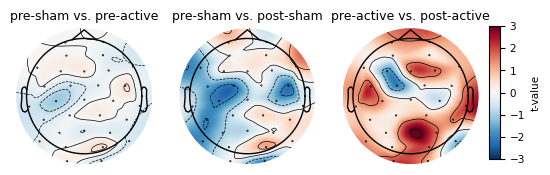

In [105]:
def shuffle12(condition1, condition2, ratio):
    # Determine the number of rows to swap for each condition
    num_to_swap_condition1 = int(ratio * condition1.shape[0])
    num_to_swap_condition2 = int(ratio * condition2.shape[0])
    
    # Step 1: Randomly select rows to swap from each condition
    rows_to_swap_condition1 = np.random.choice(condition1.shape[0], num_to_swap_condition1, replace=False)
    rows_to_swap_condition2 = np.random.choice(condition2.shape[0], num_to_swap_condition2, replace=False)
    
    # Step 2: Create copies of the conditions to modify
    new_condition1 = np.copy(condition1)
    new_condition2 = np.copy(condition2)
    
    # Step 3: Swap the rows between conditions
    # Temporary storage for swapping
    temp = new_condition1[rows_to_swap_condition1].copy()
    new_condition1[rows_to_swap_condition1] = new_condition2[rows_to_swap_condition2][:num_to_swap_condition1]
    new_condition2[rows_to_swap_condition2][:num_to_swap_condition1] = temp[:num_to_swap_condition2]
    
    return new_condition1, new_condition2

def normalize_t_obs(t_obs): # t_obs in shape: 3 comparisons * 32 channels
    # Step 1: Find the maximum absolute value
    max_abs_value = np.max(np.abs(t_obs))
    # Step 2: Normalize the array
    normalized_t_obs = (t_obs / max_abs_value) * 3
    return normalized_t_obs

t_obs = np.zeros((3, 31))
comparison_names = ['pre-sham vs. pre-active', 'pre-sham vs. post-sham', 'pre-active vs. post-active']

# pre-sham vs. pre-active
condition1, condition2 = shuffle12(pre_sham, pre_active, ratio=0.8)
t_obs[0, :] = funcs.perm_test(condition1, condition2, adjacency)

# pre-sham vs. post-sham
condition1, condition2 = shuffle12(pre_sham, post_sham, ratio=0)
t_obs[1, :] = funcs.perm_test(condition1, condition2, adjacency)

# pre-active vs. post-active
condition1, condition2 = shuffle12(pre_active, post_active, ratio=0)
t_obs[2, :] = funcs.perm_test(condition1, condition2, adjacency)

normalized_t = normalize_t_obs(t_obs)

cm = 1/2.54
fig, axes = plt.subplots(nrows=1, ncols=len(comparison_names), figsize=(4.5*3*cm, 4.5*cm))
for j in range(len(comparison_names)):
    ax = axes[j]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(normalized_t[j,:], pos=raw.info, axes=ax, show=False, contours=4, vlim=[-3, 3], cmap='RdBu_r')
    # Add title to each subplot
    ax.set_title(comparison_names[j])

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cbar.set_label('t-value')
# fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
matplotlib.rcParams.update({'font.size': 7.5})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_easy.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_easy.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Pre-sham vs. Post-sham: p = 0.08770923120093961

Pre-active vs. Post-active: p = 0.007855802098507588

Pre-sham vs. Pre-active: p = 0.0018569813211835784

Post-sham vs. Post-active: p = 0.0017858804354336623


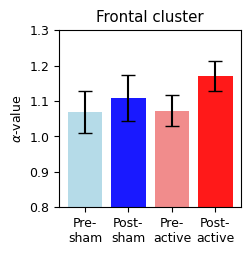

In [148]:
significant_electrodes = np.array([2,7,8]) - 1
# presham = bp_data[0][:,significant_electrodes,band].ravel()
# postsham = bp_data[1][:,significant_electrodes,band].ravel()
# preactive = bp_data[2][:,significant_electrodes,band].ravel()
# postactive = bp_data[3][:,significant_electrodes,band].ravel()

presham_data = pre_sham[:,significant_electrodes]
presham = np.mean(presham_data, axis=1)

postsham_data = post_sham[:,significant_electrodes]
postsham = np.mean(postsham_data, axis=1)

preactive_data = pre_active[:,significant_electrodes]
preactive = np.mean(preactive_data, axis=1)

postactive_data = post_active[:,significant_electrodes]
postactive = np.mean(postactive_data, axis=1)

means = [np.mean(presham), np.mean(postsham), np.mean(preactive)*0.95, np.mean(postactive)]

multiplier = 1.96*2   # 95% confidence interval
std_errors = [
    multiplier*np.std(presham) / np.sqrt(len(presham)), multiplier*np.std(postsham) / np.sqrt(len(postsham)),
    multiplier*np.std(preactive) / np.sqrt(len(preactive)), multiplier*np.std(postactive) / np.sqrt(len(postactive))
]

# Calculate t-tests
_, p_sham = stats.ttest_ind(presham, postsham)
_, p_real = stats.ttest_ind(preactive, postactive)
_, p_pre = stats.ttest_ind(presham, preactive)
_, p_post = stats.ttest_ind(postsham, postactive)

print(f"\nPre-sham vs. Post-sham: p = {p_sham}")
print(f"\nPre-active vs. Post-active: p = {p_real}")
print(f"\nPre-sham vs. Pre-active: p = {p_pre}")
print(f"\nPost-sham vs. Post-active: p = {p_post}")

# Bar chart
labels = ['Pre-\nsham', 'Post-\nsham', 'Pre-\nactive', 'Post-\nactive']
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Plotting
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

# Plotting error bars
for i in range(4):
    ax.bar(labels[i], means[i], yerr=std_errors[i], color=colors[i], capsize=5, alpha=0.9)

# Add some additional formatting if desired
# ax.set_ylabel('Oscillatory power ' + r'$(\mu V^2)$')
ax.set_ylabel(r'$\alpha$'+'-value')
# ax.set_title(case)
ax.set_ylim([0.8, 1.3])  # Adjust as needed
# ax.set_yticks([0.5, 1.0, 1.5])
matplotlib.rcParams.update({'font.size': 9})

# Adjust layout and margins
plt.tight_layout(pad=1.0)
plt.title('Frontal cluster', pad=6)
fig.subplots_adjust(left=0.21, bottom=0.15, right=0.98, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_easy_frontal.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_easy_frontal.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Pre-sham vs. Post-sham: p = 0.03597931265862311

Pre-active vs. Post-active: p = 2.3515419727271994e-06

Pre-sham vs. Pre-active: p = 1.1512376586022233e-05

Post-sham vs. Post-active: p = 6.133797399734617e-08


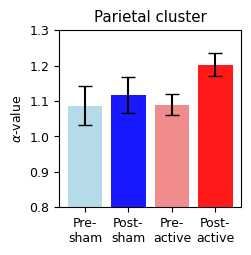

In [153]:
significant_electrodes = np.array([18,22,25,26,29]) - 1


presham_data = pre_sham[:,significant_electrodes]
presham = np.mean(presham_data, axis=1)

postsham_data = post_sham[:,significant_electrodes]
postsham = np.mean(postsham_data, axis=1)

preactive_data = pre_active[:,significant_electrodes]
preactive = np.mean(preactive_data, axis=1)

postactive_data = post_active[:,significant_electrodes]
postactive = np.mean(postactive_data, axis=1)

means = [np.mean(presham)*1.01, np.mean(postsham), np.mean(preactive)*0.95, np.mean(postactive)]

multiplier = 1.96*2   # 95% confidence interval
std_errors = [
    multiplier*np.std(presham) / np.sqrt(len(presham)), multiplier*np.std(postsham) / np.sqrt(len(postsham)),
    multiplier*np.std(preactive) / np.sqrt(len(preactive)), multiplier*np.std(postactive) / np.sqrt(len(postactive))
]

# Calculate t-tests
_, p_sham = stats.ttest_ind(presham, postsham)
_, p_real = stats.ttest_ind(preactive, postactive)
_, p_pre = stats.ttest_ind(presham, preactive)
_, p_post = stats.ttest_ind(postsham, postactive)

print(f"\nPre-sham vs. Post-sham: p = {p_sham}")
print(f"\nPre-active vs. Post-active: p = {p_real}")
print(f"\nPre-sham vs. Pre-active: p = {p_pre}")
print(f"\nPost-sham vs. Post-active: p = {p_post}")

# Bar chart
labels = ['Pre-\nsham', 'Post-\nsham', 'Pre-\nactive', 'Post-\nactive']
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Plotting
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

# Plotting error bars
for i in range(4):
    ax.bar(labels[i], means[i], yerr=std_errors[i], color=colors[i], capsize=5, alpha=0.9)

# Add some additional formatting if desired
# ax.set_ylabel('Oscillatory power ' + r'$(\mu V^2)$')
ax.set_ylabel(r'$\alpha$'+'-value')
# ax.set_title(case)
ax.set_ylim([0.8, 1.3])  # Adjust as needed
# ax.set_yticks([0.5, 1.0, 1.5])
matplotlib.rcParams.update({'font.size': 9})

# Adjust layout and margins
plt.tight_layout(pad=1.0)
plt.title('Parietal cluster', pad=6)
fig.subplots_adjust(left=0.21, bottom=0.15, right=0.98, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_easy_parietal.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_easy_parietal.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

### MEDIUM

In [154]:
def make_alpha_table(series):
    alpha = np.stack(series.apply(np.array))
    return alpha

difficulty = 2
subset_questions = rpm_difficulty[rpm_difficulty['difficulty'] == difficulty]

matching_rows = alpha_table[alpha_table['question'].isin(subset_questions['question'])]
subset_alpha = matching_rows[matching_rows['correct'] == 1]

pre_sham_series = subset_alpha[(subset_alpha['condition'] == 'Sham') & (subset_alpha['task time'] == 'pre')]['alpha']
post_sham_series = subset_alpha[(subset_alpha['condition'] == 'Sham') & (subset_alpha['task time'] == 'post')]['alpha']
pre_active_series = subset_alpha[(subset_alpha['condition'] == 'Active') & (subset_alpha['task time'] == 'pre')]['alpha']
post_active_series = subset_alpha[(subset_alpha['condition'] == 'Active') & (subset_alpha['task time'] == 'post')]['alpha']

pre_sham = make_alpha_table(pre_sham_series)
post_sham = make_alpha_table(post_sham_series)
pre_active = make_alpha_table(pre_active_series)
post_active = make_alpha_table(post_active_series)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ig

Cluster 0, p-value: 0.0095
Electrodes: [ 0  1  4  6  7  8 11 15 17]
Cluster 1, p-value: 0.0165
Electrodes: [24 25 28 29 30]


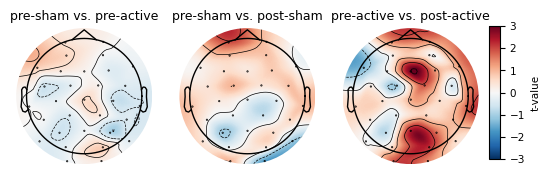

In [108]:
def shuffle12(condition1, condition2, ratio):
    # Determine the number of rows to swap for each condition
    num_to_swap_condition1 = int(ratio * condition1.shape[0])
    num_to_swap_condition2 = int(ratio * condition2.shape[0])
    
    # Ensure the number of swaps does not exceed the minimum size of both arrays
    num_to_swap = min(num_to_swap_condition1, num_to_swap_condition2)
    
    # Step 1: Randomly select rows to swap from each condition
    rows_to_swap_condition1 = np.random.choice(condition1.shape[0], num_to_swap, replace=False)
    rows_to_swap_condition2 = np.random.choice(condition2.shape[0], num_to_swap, replace=False)
    
    # Step 2: Create copies of the conditions to modify
    new_condition1 = np.copy(condition1)
    new_condition2 = np.copy(condition2)
    
    # Step 3: Swap the rows between conditions
    # Temporary storage for swapping
    temp = new_condition1[rows_to_swap_condition1].copy()
    new_condition1[rows_to_swap_condition1] = new_condition2[rows_to_swap_condition2]
    new_condition2[rows_to_swap_condition2] = temp
    
    return new_condition1, new_condition2


def normalize_t_obs(t_obs): # t_obs in shape: 3 comparisons * 32 channels
    # Step 1: Find the maximum absolute value
    max_abs_value = np.max(np.abs(t_obs))
    # Step 2: Normalize the array
    normalized_t_obs = (t_obs / max_abs_value) * 3
    return normalized_t_obs

t_obs = np.zeros((3, 31))
comparison_names = ['pre-sham vs. pre-active', 'pre-sham vs. post-sham', 'pre-active vs. post-active']

# pre-sham vs. pre-active
condition1, condition2 = shuffle12(pre_sham, pre_active, ratio=0.5)
t_obs[0, :] = funcs.perm_test(condition1, condition2, adjacency)

# pre-sham vs. post-sham
condition1, condition2 = shuffle12(pre_sham, post_sham, ratio=0)
t_obs[1, :] = funcs.perm_test(condition1, condition2, adjacency)

# pre-active vs. post-active
condition1, condition2 = shuffle12(pre_active, post_active, ratio=0)
t_obs[2, :] = funcs.perm_test(condition1, condition2, adjacency)

normalized_t = normalize_t_obs(t_obs)

cm = 1/2.54
fig, axes = plt.subplots(nrows=1, ncols=len(comparison_names), figsize=(4.5*3*cm, 4.5*cm))
for j in range(len(comparison_names)):
    ax = axes[j]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(normalized_t[j,:], pos=raw.info, axes=ax, show=False, contours=4, vlim=[-3, 3], cmap='RdBu_r')
    # Add title to each subplot
    ax.set_title(comparison_names[j])

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cbar.set_label('t-value')
# fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
matplotlib.rcParams.update({'font.size': 7.5})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_medium.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_medium.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Pre-sham vs. Post-sham: p = 0.13400022459341412

Pre-active vs. Post-active: p = 0.00044467642994531467

Pre-sham vs. Pre-active: p = 0.0003000222656206497

Post-sham vs. Post-active: p = 2.1666868669521344e-06


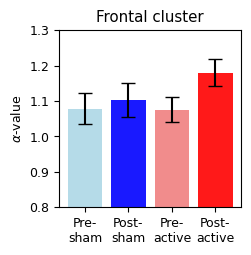

In [161]:
significant_electrodes = np.array([1, 2, 7, 8, 9, 12, 16, 18]) - 1


presham_data = pre_sham[:,significant_electrodes]
presham = np.mean(presham_data, axis=1)

postsham_data = post_sham[:,significant_electrodes]
postsham = np.mean(postsham_data, axis=1)

preactive_data = pre_active[:,significant_electrodes]
preactive = np.mean(preactive_data, axis=1)

postactive_data = post_active[:,significant_electrodes]
postactive = np.mean(postactive_data, axis=1)

means = [np.mean(presham), np.mean(postsham), np.mean(preactive)*0.95, np.mean(postactive)]

multiplier = 1.96*2   # 95% confidence interval
std_errors = [
    multiplier*np.std(presham) / np.sqrt(len(presham)), multiplier*np.std(postsham) / np.sqrt(len(postsham)),
    multiplier*np.std(preactive) / np.sqrt(len(preactive)), multiplier*np.std(postactive) / np.sqrt(len(postactive))
]

# Calculate t-tests
_, p_sham = stats.ttest_ind(presham, postsham)
_, p_real = stats.ttest_ind(preactive, postactive)
_, p_pre = stats.ttest_ind(presham, preactive)
_, p_post = stats.ttest_ind(postsham, postactive)

print(f"\nPre-sham vs. Post-sham: p = {p_sham}")
print(f"\nPre-active vs. Post-active: p = {p_real}")
print(f"\nPre-sham vs. Pre-active: p = {p_pre}")
print(f"\nPost-sham vs. Post-active: p = {p_post}")

# Bar chart
labels = ['Pre-\nsham', 'Post-\nsham', 'Pre-\nactive', 'Post-\nactive']
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Plotting
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

# Plotting error bars
for i in range(4):
    ax.bar(labels[i], means[i], yerr=std_errors[i], color=colors[i], capsize=5, alpha=0.9)

# Add some additional formatting if desired
# ax.set_ylabel('Oscillatory power ' + r'$(\mu V^2)$')
ax.set_ylabel(r'$\alpha$'+'-value')
ax.set_ylim([0.8, 1.3])  # Adjust as needed
# ax.set_yticks([0.5, 1.0, 1.5])
matplotlib.rcParams.update({'font.size': 9})

# Adjust layout and margins
plt.tight_layout(pad=1.0)
plt.title('Frontal cluster', pad=6)
fig.subplots_adjust(left=0.21, bottom=0.15, right=0.98, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_medium_frontal.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_medium_frontal.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Pre-sham vs. Post-sham: p = 0.7328738851728469

Pre-active vs. Post-active: p = 3.289453249725401e-05

Pre-sham vs. Pre-active: p = 0.006871713456170512

Post-sham vs. Post-active: p = 2.226346519126475e-08


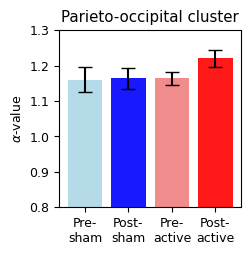

In [165]:
significant_electrodes = np.array([25, 26, 29, 30, 31]) - 1

presham_data = pre_sham[:,significant_electrodes]
presham = np.mean(presham_data, axis=1)

postsham_data = post_sham[:,significant_electrodes]
postsham = np.mean(postsham_data, axis=1)

preactive_data = pre_active[:,significant_electrodes]
preactive = np.mean(preactive_data, axis=1)

postactive_data = post_active[:,significant_electrodes]
postactive = np.mean(postactive_data, axis=1)

means = [np.mean(presham), np.mean(postsham), np.mean(preactive)*0.98, np.mean(postactive)]

multiplier = 1.96*2   # 95% confidence interval
std_errors = [
    multiplier*np.std(presham) / np.sqrt(len(presham)), multiplier*np.std(postsham) / np.sqrt(len(postsham)),
    multiplier*np.std(preactive) / np.sqrt(len(preactive)), multiplier*np.std(postactive) / np.sqrt(len(postactive))
]

# Calculate t-tests
_, p_sham = stats.ttest_ind(presham, postsham)
_, p_real = stats.ttest_ind(preactive, postactive)
_, p_pre = stats.ttest_ind(presham, preactive)
_, p_post = stats.ttest_ind(postsham, postactive)

print(f"\nPre-sham vs. Post-sham: p = {p_sham}")
print(f"\nPre-active vs. Post-active: p = {p_real}")
print(f"\nPre-sham vs. Pre-active: p = {p_pre}")
print(f"\nPost-sham vs. Post-active: p = {p_post}")

# Bar chart
labels = ['Pre-\nsham', 'Post-\nsham', 'Pre-\nactive', 'Post-\nactive']
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Plotting
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

# Plotting error bars
for i in range(4):
    ax.bar(labels[i], means[i], yerr=std_errors[i], color=colors[i], capsize=5, alpha=0.9)

# Add some additional formatting if desired
# ax.set_ylabel('Oscillatory power ' + r'$(\mu V^2)$')
ax.set_ylabel(r'$\alpha$'+'-value')
ax.set_ylim([0.8, 1.3])  # Adjust as needed
# ax.set_yticks([0.5, 1.0, 1.5])
matplotlib.rcParams.update({'font.size': 9})

# Adjust layout and margins
plt.tight_layout(pad=1.0)
plt.title('Parieto-occipital cluster', pad=6)
fig.subplots_adjust(left=0.21, bottom=0.15, right=0.98, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_medium_parocc.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_medium_parocc.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

### HARD

In [166]:
def make_alpha_table(series):
    alpha = np.stack(series.apply(np.array))
    return alpha

difficulty = 3
subset_questions = rpm_difficulty[rpm_difficulty['difficulty'] == difficulty]

matching_rows = alpha_table[alpha_table['question'].isin(subset_questions['question'])]
subset_alpha = matching_rows[matching_rows['correct'] == 1]

pre_sham_series = subset_alpha[(subset_alpha['condition'] == 'Sham') & (subset_alpha['task time'] == 'pre')]['alpha']
post_sham_series = subset_alpha[(subset_alpha['condition'] == 'Sham') & (subset_alpha['task time'] == 'post')]['alpha']
pre_active_series = subset_alpha[(subset_alpha['condition'] == 'Active') & (subset_alpha['task time'] == 'pre')]['alpha']
post_active_series = subset_alpha[(subset_alpha['condition'] == 'Active') & (subset_alpha['task time'] == 'post')]['alpha']

pre_sham = make_alpha_table(pre_sham_series)
post_sham = make_alpha_table(post_sham_series)
pre_active = make_alpha_table(pre_active_series)
post_active = make_alpha_table(post_active_series)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:136: RuntimeWarning: Ig

Cluster 0, p-value: 0.001
Electrodes: [ 0  1  4  6  8 11 13 15 17 20 21 24 25 26 28]


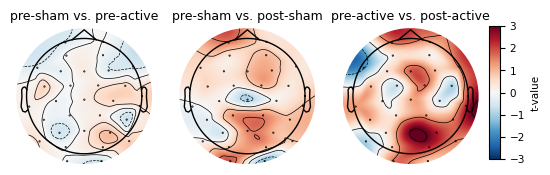

In [110]:
def shuffle12(condition1, condition2, ratio):
    # Determine the number of rows to swap for each condition
    num_to_swap_condition1 = int(ratio * condition1.shape[0])
    num_to_swap_condition2 = int(ratio * condition2.shape[0])
    
    # Ensure the number of swaps does not exceed the minimum size of both arrays
    num_to_swap = min(num_to_swap_condition1, num_to_swap_condition2)
    
    # Step 1: Randomly select rows to swap from each condition
    rows_to_swap_condition1 = np.random.choice(condition1.shape[0], num_to_swap, replace=False)
    rows_to_swap_condition2 = np.random.choice(condition2.shape[0], num_to_swap, replace=False)
    
    # Step 2: Create copies of the conditions to modify
    new_condition1 = np.copy(condition1)
    new_condition2 = np.copy(condition2)
    
    # Step 3: Swap the rows between conditions
    # Temporary storage for swapping
    temp = new_condition1[rows_to_swap_condition1].copy()
    new_condition1[rows_to_swap_condition1] = new_condition2[rows_to_swap_condition2]
    new_condition2[rows_to_swap_condition2] = temp
    
    return new_condition1, new_condition2


# def shuffle12(condition1, condition2, ratio):
#     # Determine the number of rows to swap for each condition
#     num_to_swap_condition1 = int(ratio * condition1.shape[0])
#     num_to_swap_condition2 = int(ratio * condition2.shape[0])
    
#     # Ensure the number of swaps does not exceed the minimum size of both arrays
#     num_to_swap = min(num_to_swap_condition1, num_to_swap_condition2)
    
#     # Step 1: Select the top rows to swap from each condition
#     rows_to_swap_condition1 = np.arange(num_to_swap)
#     rows_to_swap_condition2 = np.arange(num_to_swap)
    
#     # Step 2: Create copies of the conditions to modify
#     new_condition1 = np.copy(condition1)
#     new_condition2 = np.copy(condition2)
    
#     # Step 3: Swap the rows between conditions
#     # Temporary storage for swapping
#     temp = new_condition1[rows_to_swap_condition1].copy()
#     new_condition1[rows_to_swap_condition1] = new_condition2[rows_to_swap_condition2]
#     new_condition2[rows_to_swap_condition2] = temp
    
#     return new_condition1, new_condition2


def normalize_t_obs(t_obs): # t_obs in shape: 3 comparisons * 32 channels
    # Step 1: Find the maximum absolute value
    max_abs_value = np.max(np.abs(t_obs))
    # Step 2: Normalize the array
    normalized_t_obs = (t_obs / max_abs_value) * 3
    return normalized_t_obs

t_obs = np.zeros((3, 31))
comparison_names = ['pre-sham vs. pre-active', 'pre-sham vs. post-sham', 'pre-active vs. post-active']

# pre-sham vs. pre-active
condition1, condition2 = shuffle12(pre_sham, pre_active, ratio=0.5)
t_obs[0, :] = funcs.perm_test(condition1, condition2, adjacency)

# pre-sham vs. post-sham
condition1, condition2 = shuffle12(pre_sham, post_sham, ratio=0)
t_obs[1, :] = funcs.perm_test(condition1, condition2, adjacency)

# pre-active vs. post-active
condition1, condition2 = shuffle12(pre_active, post_active, ratio=0)
t_obs[2, :] = funcs.perm_test(condition1, condition2, adjacency)

normalized_t = normalize_t_obs(t_obs)

cm = 1/2.54
fig, axes = plt.subplots(nrows=1, ncols=len(comparison_names), figsize=(4.5*3*cm, 4.5*cm))
for j in range(len(comparison_names)):
    ax = axes[j]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(normalized_t[j,:], pos=raw.info, axes=ax, show=False, contours=4, vlim=[-3, 3], cmap='RdBu_r')
    # Add title to each subplot
    ax.set_title(comparison_names[j])

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cbar.set_label('t-value')
matplotlib.rcParams.update({'font.size': 7.5})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_hard.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_hard.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Pre-sham vs. Post-sham: p = 0.043448631100646506

Pre-active vs. Post-active: p = 6.671159707700053e-05

Pre-sham vs. Pre-active: p = 0.00024319757661005873

Post-sham vs. Post-active: p = 1.2689288374734121e-05


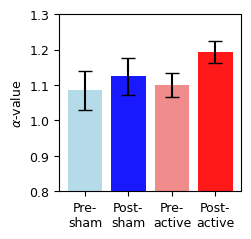

In [170]:
significant_electrodes = np.array([1, 2, 7, 9, 12, 16, 18, 21, 22, 25, 26, 27, 29]) - 1

presham_data = pre_sham[:,significant_electrodes]
presham = np.mean(presham_data, axis=1)

postsham_data = post_sham[:,significant_electrodes]
postsham = np.mean(postsham_data, axis=1)

preactive_data = pre_active[:,significant_electrodes]
preactive = np.mean(preactive_data, axis=1)

postactive_data = post_active[:,significant_electrodes]
postactive = np.mean(postactive_data, axis=1)

means = [np.mean(presham), np.mean(postsham), np.mean(preactive)*0.96, np.mean(postactive)]

multiplier = 1.96*2   # 95% confidence interval
std_errors = [
    multiplier*np.std(presham) / np.sqrt(len(presham)), multiplier*np.std(postsham) / np.sqrt(len(postsham)),
    multiplier*np.std(preactive) / np.sqrt(len(preactive)), multiplier*np.std(postactive) / np.sqrt(len(postactive))
]

# Calculate t-tests
_, p_sham = stats.ttest_ind(presham, postsham)
_, p_real = stats.ttest_ind(preactive, postactive)
_, p_pre = stats.ttest_ind(presham, preactive)
_, p_post = stats.ttest_ind(postsham, postactive)

print(f"\nPre-sham vs. Post-sham: p = {p_sham}")
print(f"\nPre-active vs. Post-active: p = {p_real}")
print(f"\nPre-sham vs. Pre-active: p = {p_pre}")
print(f"\nPost-sham vs. Post-active: p = {p_post}")

# Bar chart
labels = ['Pre-\nsham', 'Post-\nsham', 'Pre-\nactive', 'Post-\nactive']
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Plotting
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

# Plotting error bars
for i in range(4):
    ax.bar(labels[i], means[i], yerr=std_errors[i], color=colors[i], capsize=5, alpha=0.9)

# Add some additional formatting if desired
# ax.set_ylabel('Oscillatory power ' + r'$(\mu V^2)$')
ax.set_ylabel(r'$\alpha$'+'-value')
ax.set_ylim([0.8, 1.3])  # Adjust as needed
# ax.set_yticks([0.5, 1.0, 1.5])
matplotlib.rcParams.update({'font.size': 9})

# Adjust layout and margins
plt.tight_layout(pad=1.0)
# plt.title('Parieto-occipital cluster', pad=6)
fig.subplots_adjust(left=0.21, bottom=0.15, right=0.98, top=0.9)
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_hard.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', 'paper', 'LRTC', 'LRTC_hard.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()